In [117]:
#! conda install networkx -y

In [118]:
import numpy as np
import itertools
import math
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

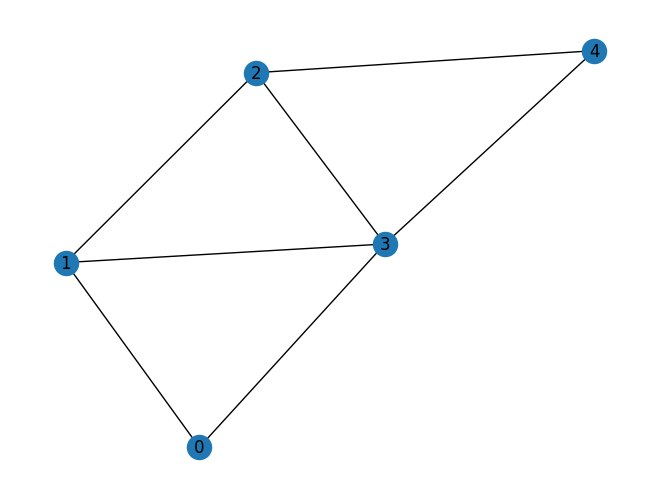

In [119]:
# Parameters
n = 5
epsilon = 1/(2*n)
graph_type = 'random' # 'random' or 'line' or 'complete'

# Randomness
gen = np.random.default_rng(1)

# Create a graph with n nodes
graph = nx.Graph()
graph.add_nodes_from(range(n))
if graph_type == 'complete':
    graph.add_edges_from(itertools.combinations(range(n), 2))
elif graph_type == 'line':
    graph.add_edges_from([(i, i+1) for i in range(n-1)])
elif graph_type == 'random':
    for i, j in itertools.combinations(range(n), 2):
        if gen.random() < 0.6: graph.add_edge(i, j)

# Visualize the graph
# Fix the positions of the nodes
nx.draw(graph, with_labels=True)

v_vector = gen.random(2**n)
v_vector -= v_vector[0]

## Utility Methods

In [120]:
def extract_singleton_from_vector(v_vector, n):
    single = np.zeros(n)
    for i in range(n):
        index = 2**i - 1
        single[i] = v_vector[index]
    return single

def convert_from_vector_to_dict(v_vector, n):
    v_dict = {}
    for idx in range(2**n):
        subset = tuple([j for j in range(n) if (idx >> j) & 1])
        v_dict[subset] = v_vector[idx]
    return v_dict

def extract_singleton_from_dict(v_dict, n):
    single = np.zeros(n)
    for i in range(n):
        single[i] = v_dict[tuple([i])]
    return single

def print_labelled_matrix(P, do_round=True):
    if do_round: P = P.round(3)
    df = pd.DataFrame(P)

    def subset_to_string(subset):
        return str([j for j in subset])

    for idx in range(2**n-1):
        subset = [j for j in range(n) if (idx + 1 >> j) & 1]
        df = df.rename(index={idx: subset_to_string(subset)})
        df = df.rename(columns={idx: subset_to_string(subset)})
    # if number of columns is n then reset col labels to 0, 1, 2, ..., n
    if df.shape[1] == n:
        df.columns = [str([i]) for i in range(n)]

    print(df)

## Computing Shapley Values

In [121]:
def compute_shapley_values_vector(n, v_vector):
    shap_values = np.zeros(n)
    for i in range(n):
        valid_items = [j for j in range(n) if j != i]
        for set_size in range(n):
            # Generate all subsets of size set_size
            weight = 1 / math.comb(n - 1, set_size)
            for subset in itertools.combinations(valid_items, set_size):
                # All indices from 0 to 2**n correspond to a subset
                # Convert from a subset to the associated index
                index_wo_i = sum([2**j for j in subset])
                index_w_i = index_wo_i + 2**i
                shap_values[i] += weight * (v_vector[index_w_i] - v_vector[index_wo_i])
    return shap_values / n

def compute_shapley_values_dict(n, v_dict):
    shap_values = np.zeros(n)
    for i in range(n):
        valid_items = [j for j in range(n) if j != i]
        for set_size in range(n):
            # Generate all subsets of size set_size
            weight = 1 / math.comb(n - 1, set_size)
            for subset in itertools.combinations(valid_items, set_size):
                subset = tuple(subset)
                subset_wo_i = subset
                subset_w_i = list(subset) + [i]
                subset_w_i.sort()
                subset_w_i = tuple(subset_w_i)
                shap_values[i] += weight * (v_dict[subset_w_i] - v_dict[subset_wo_i])
    return shap_values / n

## Shared Methods

In [122]:
def build_psi(n, epsilon):
    non_identity = np.zeros((2**n-1, 2**n-1))

    for row_idx in range(2**n-1):
        subset = [j for j in range(n) if (row_idx + 1 >> j) & 1]
        not_in_subset = [j for j in range(n) if j not in subset]
        non_identity[row_idx, row_idx] = -1 * len(not_in_subset)

        for j in not_in_subset:
           subset_with_j = subset + [j]
           subset_with_j.sort()
           subset_with_j_idx = sum([2**i for i in subset_with_j]) - 1
           non_identity[row_idx, subset_with_j_idx] = 1
           non_identity[row_idx, 2**j-1] = -1

    return np.eye(2**n-1) + epsilon * non_identity

def build_psi_graph(n, graph, epsilon):
    psi = np.zeros((2**n-1, 2**n-1))
    for row_idx in range(2**n-1):
        subset = [j for j in range(n) if (row_idx + 1 >> j) & 1]
        graph_subset = graph.subgraph(subset)
        for connected_component in nx.connected_components(graph_subset):
            nodes = list(connected_component)
            # Neighbors of nodes in the connected component
            neighbors = set()
            for node in nodes:
                neighbors |= set(graph.neighbors(node))
            neighbors -= set(nodes)
            nodes_idx = sum([2**i for i in nodes]) - 1
            psi[row_idx, nodes_idx] += 1 - epsilon * len(neighbors)

            for j in neighbors:
                nodes_w_j_idx = nodes_idx + 2**j
                psi[row_idx, nodes_w_j_idx] += epsilon
                psi[row_idx, 2**j-1] += -epsilon
    return psi

def build_proj_graph(n, graph):
    proj = np.zeros((2**n-1, 2**n-1))
    for row_idx in range(2**n-1):
        subset = [j for j in range(n) if (row_idx + 1 >> j) & 1]
        graph_subset = graph.subgraph(subset)
        for connected_component in nx.connected_components(graph_subset):
            nodes = list(connected_component)
            nodes_idx = sum([2**i for i in nodes]) - 1
            proj[row_idx, nodes_idx] = 1
    return proj

def compute_next_v_graph_dict(v, n, graph, epsilon):
    next_v = {}
    for idx in range(2**n):
        subset = tuple([j for j in range(n) if (idx >> j) & 1])
        graph_subset = graph.subgraph(subset)
        summation = 0
        for connected_component in nx.connected_components(graph_subset):
            nodes = list(connected_component)
            # Neighbors of nodes in the connected component
            neighbors = set()
            for node in nodes:
                neighbors |= set(graph.neighbors(node))
            neighbors -= set(nodes)
            summation += (1 - epsilon * len(neighbors)) * v[tuple(nodes)]
            for j in neighbors:
                nodes_w_j = list(nodes) + [j]
                nodes_w_j.sort()
                summation += epsilon * (v[tuple(nodes_w_j)] - v[tuple([j])])

        next_v[subset] = summation
    return next_v

def compute_next_v_dict(v, n, epsilon):
    next_v = {}
    for idx in range(2**n):
        subset = tuple([j for j in range(n) if (idx >> j) & 1])
        not_in_subset = [j for j in range(n) if j not in subset]
        summation = 0
        for j in not_in_subset:
            subset_with_j = list(subset) + [j]
            subset_with_j.sort()
            subset_with_j = tuple(subset_with_j)
            j = tuple([j])
            summation += v[subset_with_j] - v[j] - v[subset]

        next_v[subset] = v[subset] + epsilon * summation
    return next_v



## Computing Shapley Values

In [123]:
shap_values = compute_shapley_values_vector(n, v_vector)
print('Shapley values from vector:', shap_values)

Psi = build_psi(n, epsilon)
next_v = v_vector[1:]

for j in range(100):
    next_v = Psi @ next_v

print('Shapley values from matvec:', extract_singleton_from_vector(next_v, n))

next_Psi = Psi
for j in range(100):
    next_Psi = next_Psi @ Psi

print('Shapley values from matrix:', extract_singleton_from_vector(next_Psi @ v_vector[1:], n))

v_dict = convert_from_vector_to_dict(v_vector, n)

shap_values = compute_shapley_values_dict(n, v_dict)
print('Shapley values from dictio:', shap_values)

next_v = v_dict
for i in range(100):
    next_v = compute_next_v_dict(next_v, n, epsilon)

print('Shapley values from limitd:', extract_singleton_from_dict(next_v, n))

Shapley values from vector: [ 0.05338079  0.11795548 -0.00346169 -0.03901137 -0.02974347]
Shapley values from matvec: [ 0.05338079  0.11795548 -0.00346169 -0.03901137 -0.02974347]
Shapley values from matrix: [ 0.05338079  0.11795548 -0.00346169 -0.03901137 -0.02974347]
Shapley values from dictio: [ 0.05338079  0.11795548 -0.00346169 -0.03901137 -0.02974347]
Shapley values from limitd: [ 0.05338079  0.11795548 -0.00346169 -0.03901137 -0.02974347]


## Speeding up Limit

In [124]:
def build_unanimity_basis(n, is_inverse=False):
    P = np.zeros((2**n-1, 2**n-1))
    for idx in range(2**n-1):
        subset = [j for j in range(n) if (idx + 1 >> j) & 1]
        #print(subset)
        # for all supersets of subset
        remaining = [j for j in range(n) if j not in subset]
        for length in range(len(remaining)+1):
            for new_subset in itertools.combinations(remaining, length):
                new_subset = subset + list(new_subset)
                new_subset_idx = sum([2**i for i in new_subset]) -1
                P[new_subset_idx, idx] = 1
                if is_inverse:
                    if len(new_subset) % 2 != len(subset) % 2 and len(new_subset) > len(subset):
                        P[new_subset_idx, idx] = -1
    return P

def build_triangular(n, epsilon):
    triangular = np.zeros((2**n-1, 2**n-1))
    for idx in range(2**n-1):
        subset = [j for j in range(n) if (idx + 1 >> j) & 1]
        if len(subset) == 1:
            triangular[idx,idx] = 1
        else:
            triangular[idx,idx] = 1 - epsilon * len(subset)
            for i in subset:
                triangular[idx - 2**i, idx] = epsilon
    return triangular

def build_triangular_graph(n, graph, epsilon):
    triangular = np.zeros((2**n-1, 2**n-1))
    for idx in range(2**n-1):
        subset = [j for j in range(n) if (idx + 1 >> j) & 1] 
        if len(subset) == 1:
            triangular[idx,idx] = 1 
            continue
        graph_subset = graph.subgraph(subset)
        #if nx.is_connected(graph_subset):
        for connected_component in nx.connected_components(graph_subset):
            nodes = list(connected_component)
            # Neighbors of nodes in the connected component
            neighbors = set()
            for node in nodes:
                neighbors |= set(graph.neighbors(node))
            neighbors -= set(nodes)
            nodes_idx = sum([2**i for i in nodes]) - 1
            triangular[nodes_idx, idx] += 1- epsilon * len(neighbors)
            for i in neighbors:
                triangular[nodes_idx - 2**i, idx] += epsilon
    return triangular

def build_tri_limit(n):
    tri = np.zeros((2**n-1, 2**n-1))
    for j in range(n):
        row_idx = 2**j - 1
        valid_items = [i for i in range(n) if j != i]
        for set_size in range(n):
            for subset in itertools.combinations(valid_items, set_size):
                col_idx = sum([2**i for i in subset]) - 1 + 2**j
                tri[row_idx, col_idx] = 1/(set_size+1)
    return tri

## HN Values

In [125]:
unanimity = build_unanimity_basis(n)
unanimity_inv = build_unanimity_basis(n, is_inverse=True)
Psi = build_psi_graph(n, graph, epsilon)
print('Triangular graph matrix:')
print_labelled_matrix((unanimity_inv @ Psi @ unanimity).round(3))

triangular = build_triangular(n, epsilon)
print('Triangular matrix:')
print_labelled_matrix(triangular)
next_v = v_vector[1:]

for j in range(50):
    next_v = Psi @ next_v

print('HamNava values from matvec:', extract_singleton_from_vector(next_v, n))

next_Psi = Psi
for j in range(60):
    next_Psi = next_Psi @ Psi

print('HamNava values from matrix:', extract_singleton_from_vector(next_Psi @ v_vector[1:], n))

v_dict = convert_from_vector_to_dict(v_vector, n)

next_v = v_dict
for i in range(100):
    next_v = compute_next_v_graph_dict(next_v, n, graph, epsilon)

print('HamNava values from limitd:', extract_singleton_from_dict(next_v, n))


triangular = build_triangular_graph(n, graph, epsilon)
empirical_limit = triangular
for j in range(10):
    empirical_limit = empirical_limit @ empirical_limit

limiting_vec = unanimity @ empirical_limit @ unanimity_inv @ v_vector[1:]
print('HamNava values from shorte:', extract_singleton_from_vector(limiting_vec, n))

Triangular graph matrix:
                 [0]  [1]  [0, 1]  [2]  [0, 2]  [1, 2]  [0, 1, 2]  [3]  \
[0]              1.0  0.0     0.1  0.0     0.0     0.0        0.0  0.0   
[1]              0.0  1.0     0.1  0.0     0.0     0.1        0.0  0.0   
[0, 1]           0.0  0.0     0.8  0.0     0.1     0.0        0.1  0.0   
[2]              0.0  0.0     0.0  1.0     0.0     0.1        0.0  0.0   
[0, 2]           0.0  0.0     0.0  0.0     0.0     0.0        0.0  0.0   
[1, 2]           0.0  0.0     0.0 -0.0     0.1     0.8        0.1  0.0   
[0, 1, 2]        0.0  0.0     0.0  0.0     0.8     0.0        0.8  0.0   
[3]              0.0  0.0     0.0  0.0     0.0     0.0        0.0  1.0   
[0, 3]          -0.0  0.0     0.0  0.0     0.1     0.0        0.0 -0.0   
[1, 3]           0.0  0.0     0.0  0.0     0.0     0.0        0.0 -0.0   
[0, 1, 3]        0.0  0.0    -0.0  0.0    -0.1     0.0        0.0  0.0   
[2, 3]           0.0  0.0     0.0  0.0     0.1     0.0        0.0  0.0   
[0, 2, 3]    

In [126]:
psi_wo_graph = build_psi(n, epsilon)

psi_w_graph = build_psi_graph(n, graph, epsilon)

proj = build_proj_graph(n, graph)

tri_wo_graph = build_triangular(n, epsilon)
tri_limit_wo_graph = build_tri_limit(n)

unanimity = build_unanimity_basis(n, is_inverse=False)
unanimity_inv = build_unanimity_basis(n, is_inverse=True)

assert np.allclose(psi_wo_graph, unanimity @ tri_wo_graph @ unanimity_inv)

def power_up(matrix, iterations):
    powered = matrix.copy()
    for i in range(iterations):
        powered = powered @ matrix
    return powered

def extract_rows(matrix):
    n = int(np.log2(matrix.shape[0] + 1))
    rows = np.array([2**i - 1 for i in range(n)])
    return matrix[rows].T

iterations = 50
#print_labelled_matrix(power_up(psi_wo_graph, iterations))
print_labelled_matrix(extract_rows(unanimity_inv @ power_up(psi_w_graph, iterations) @ unanimity))
#print_labelled_matrix(tri_limit_wo_graph)
#print_labelled_matrix(power_up(psi_wo_graph, iterations))
#print_labelled_matrix(proj @ power_up(psi_wo_graph @ proj, iterations))

                   [0]    [1]    [2]    [3]    [4]
[0]              1.000  0.000 -0.000 -0.000 -0.000
[1]              0.000  1.000 -0.000 -0.000  0.000
[0, 1]           0.500  0.500 -0.000 -0.000 -0.000
[2]             -0.000  0.000  1.000 -0.000  0.000
[0, 2]           0.333  0.167  0.333  0.167  0.000
[1, 2]           0.000  0.500  0.500 -0.000  0.000
[0, 1, 2]        0.278  0.389  0.278  0.056  0.000
[3]             -0.000 -0.000 -0.000  1.000  0.000
[0, 3]           0.500  0.000 -0.000  0.500 -0.000
[1, 3]           0.000  0.500 -0.000  0.500  0.000
[0, 1, 3]        0.333  0.333 -0.000  0.333 -0.000
[2, 3]          -0.000 -0.000  0.500  0.500  0.000
[0, 2, 3]        0.278  0.056  0.278  0.389  0.000
[1, 2, 3]        0.000  0.333  0.333  0.333  0.000
[0, 1, 2, 3]     0.222  0.278  0.222  0.278  0.000
[4]             -0.000 -0.000 -0.000 -0.000  1.000
[0, 4]           0.278  0.083  0.083  0.278  0.278
[1, 4]           0.000  0.333  0.167  0.167  0.333
[0, 1, 4]        0.222  0.287  

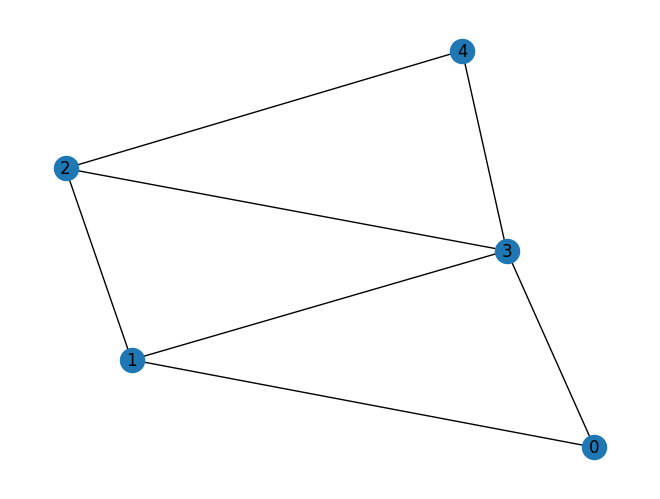

In [127]:
nx.draw(graph, with_labels=True)

## Matrix in the Limit

In [128]:
def build_short_matrix(n):
    short = np.zeros((n, 2**n-1))
    for j in range(n):
        valid_items = [i for i in range(n) if j != i]
        for idx in range(2**n-1):
            subset = [i for i in range(n) if (idx + 1 >> i) & 1]
            size = len(subset)
            size_w_j = size + 1 if j not in subset else size
            #value = 0
            #for ell in range(size_w_j, n+1):
            #    value += 1/ell * (-1) ** (ell - size) \
            #        * math.comb(n - size_w_j, ell - size_w_j)
            value = -1/(math.comb(n-1, size) *n) if j not in subset else 1/(math.comb(n-1, size-1) *n)
            short[j, idx] = value
    return short

analytical_norm = []
for idx in range(2**n-1):
    subset = [i for i in range(n) if (idx+1>>i) & 1]
    s = len(subset)
    if s < n:
        l2_norm = 1 / n * 1 / math.comb(n, s) * (1 / math.comb(n-1, s-1) + 1/ math.comb(n-1, s))
    else:
        l2_norm = 1/n
    analytical_norm.append(l2_norm)

short = build_short_matrix(n)

print(np.array(analytical_norm))

print(np.linalg.norm(short, axis=0)**2)

print_labelled_matrix(short)


short @ v_vector[1:]

[0.05       0.05       0.00833333 0.05       0.00833333 0.00833333
 0.00833333 0.05       0.00833333 0.00833333 0.00833333 0.00833333
 0.00833333 0.00833333 0.05       0.05       0.00833333 0.00833333
 0.00833333 0.00833333 0.00833333 0.00833333 0.05       0.00833333
 0.00833333 0.00833333 0.05       0.00833333 0.05       0.05
 0.2       ]
[0.05       0.05       0.00833333 0.05       0.00833333 0.00833333
 0.00833333 0.05       0.00833333 0.00833333 0.00833333 0.00833333
 0.00833333 0.00833333 0.05       0.05       0.00833333 0.00833333
 0.00833333 0.00833333 0.00833333 0.00833333 0.05       0.00833333
 0.00833333 0.00833333 0.05       0.00833333 0.05       0.05
 0.2       ]
         [0]   [1]  [0, 1]   [2]  [0, 2]  [1, 2]  [0, 1, 2]   [3]  [0, 3]  \
[0]     0.20 -0.05   0.050 -0.05   0.050  -0.033      0.033 -0.05   0.050   
[1]    -0.05  0.20   0.050 -0.05  -0.033   0.050      0.033 -0.05  -0.033   
[0, 1] -0.05 -0.05  -0.033  0.20   0.050   0.050      0.033 -0.05  -0.033   
[2]    -

array([ 0.05338079,  0.11795548, -0.00346169, -0.03901137, -0.02974347])

In [129]:



triangular = build_triangular(n, epsilon)

print_labelled_matrix(triangular)

#triangular = build_triangular_graph(n, graph, epsilon)

print_labelled_matrix(triangular)

empirical_tri_limit = np.linalg.matrix_power(triangular, 1000)

P = build_unanimity_basis(n)
P_inv = build_unanimity_basis(n, is_inverse=True)

tri_limit = build_tri_limit(n)

tri_limit = empirical_tri_limit

print_labelled_matrix(tri_limit)

result = P @ (tri_limit @ (P_inv @ v_vector[1:]))

print(extract_singleton_from_vector(result,n))


                 [0]  [1]  [0, 1]  [2]  [0, 2]  [1, 2]  [0, 1, 2]  [3]  \
[0]              1.0  0.0     0.1  0.0     0.1     0.0        0.0  0.0   
[1]              0.0  1.0     0.1  0.0     0.0     0.1        0.0  0.0   
[0, 1]           0.0  0.0     0.8  0.0     0.0     0.0        0.1  0.0   
[2]              0.0  0.0     0.0  1.0     0.1     0.1        0.0  0.0   
[0, 2]           0.0  0.0     0.0  0.0     0.8     0.0        0.1  0.0   
[1, 2]           0.0  0.0     0.0  0.0     0.0     0.8        0.1  0.0   
[0, 1, 2]        0.0  0.0     0.0  0.0     0.0     0.0        0.7  0.0   
[3]              0.0  0.0     0.0  0.0     0.0     0.0        0.0  1.0   
[0, 3]           0.0  0.0     0.0  0.0     0.0     0.0        0.0  0.0   
[1, 3]           0.0  0.0     0.0  0.0     0.0     0.0        0.0  0.0   
[0, 1, 3]        0.0  0.0     0.0  0.0     0.0     0.0        0.0  0.0   
[2, 3]           0.0  0.0     0.0  0.0     0.0     0.0        0.0  0.0   
[0, 2, 3]        0.0  0.0     0.0  0.0

In [130]:
print_labelled_matrix(build_tri_limit(n).round(2))

                 [0]  [1]  [0, 1]  [2]  [0, 2]  [1, 2]  [0, 1, 2]  [3]  \
[0]              1.0  0.0     0.5  0.0     0.5     0.0       0.33  0.0   
[1]              0.0  1.0     0.5  0.0     0.0     0.5       0.33  0.0   
[0, 1]           0.0  0.0     0.0  0.0     0.0     0.0       0.00  0.0   
[2]              0.0  0.0     0.0  1.0     0.5     0.5       0.33  0.0   
[0, 2]           0.0  0.0     0.0  0.0     0.0     0.0       0.00  0.0   
[1, 2]           0.0  0.0     0.0  0.0     0.0     0.0       0.00  0.0   
[0, 1, 2]        0.0  0.0     0.0  0.0     0.0     0.0       0.00  0.0   
[3]              0.0  0.0     0.0  0.0     0.0     0.0       0.00  1.0   
[0, 3]           0.0  0.0     0.0  0.0     0.0     0.0       0.00  0.0   
[1, 3]           0.0  0.0     0.0  0.0     0.0     0.0       0.00  0.0   
[0, 1, 3]        0.0  0.0     0.0  0.0     0.0     0.0       0.00  0.0   
[2, 3]           0.0  0.0     0.0  0.0     0.0     0.0       0.00  0.0   
[0, 2, 3]        0.0  0.0     0.0  0.0

In [131]:
print_labelled_matrix(empirical_tri_limit.round(2))

                 [0]  [1]  [0, 1]  [2]  [0, 2]  [1, 2]  [0, 1, 2]  [3]  \
[0]              1.0  0.0     0.5  0.0     0.5     0.0       0.33  0.0   
[1]              0.0  1.0     0.5  0.0     0.0     0.5       0.33  0.0   
[0, 1]           0.0  0.0     0.0  0.0     0.0     0.0       0.00  0.0   
[2]              0.0  0.0     0.0  1.0     0.5     0.5       0.33  0.0   
[0, 2]           0.0  0.0     0.0  0.0     0.0     0.0       0.00  0.0   
[1, 2]           0.0  0.0     0.0  0.0     0.0     0.0       0.00  0.0   
[0, 1, 2]        0.0  0.0     0.0  0.0     0.0     0.0       0.00  0.0   
[3]              0.0  0.0     0.0  0.0     0.0     0.0       0.00  1.0   
[0, 3]           0.0  0.0     0.0  0.0     0.0     0.0       0.00  0.0   
[1, 3]           0.0  0.0     0.0  0.0     0.0     0.0       0.00  0.0   
[0, 1, 3]        0.0  0.0     0.0  0.0     0.0     0.0       0.00  0.0   
[2, 3]           0.0  0.0     0.0  0.0     0.0     0.0       0.00  0.0   
[0, 2, 3]        0.0  0.0     0.0  0.0